# Robot that Promotes Physical Distancing

Social distancing is the practice of purposefully reducing close contact between people. Social distancing is crucial for preventing the spread of contagious illnesses such as COVID-19 (coronavirus). 
COVID-19 can spread through coughing, sneezing and close contact. Minimizing the amount of close contact, will reduce chances of catching the virus and spreading.

Even though physical distancing is defined between 2 people, robots come handy in this scenario too! Assume a cashier or a bank agent that needs the client to keep the distance of more than 6 feet to the counter. In this case a robot/robot eye that can estimate the client's distance and gives warning could come useful. Or imagine a humanoid robot that wants to keep the distance from people so that it won't carry the virus!

<img src="./images/robot.jpg">

## Algorithm

In this notebook we will go through human distance estimation algorithm. In this algorithm we use and combine human pose detection ([OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose)) and depth estimation ([DenseDepth](https://github.com/ialhashim/DenseDepth)). Here we estimate depth from RGB images without need to use depth sensors. 

<img src="./images/approach.png">

# Requirements
 - use module cuda 10.1

 - install cudnn 7.6.5 as described here: https://medium.com/@vitali.usau/install-cuda-10-0-cudnn-7-3-and-build-tensorflow-gpu-from-source-on-ubuntu-18-04-3daf720b83fe

 - install tensorflow-gpu 1.14 using pip or conda

 - install keras & opencv-contrib-python using pip or conda

In [1]:
import os
import glob
import numpy as np
import matplotlib
import cv2 as cv
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
from utils import predict, load_images, to_multichannel

Using TensorFlow backend.
/local-scratch/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/local-scratch/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/local-scratch/anaconda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/local-scratch/anaconda/lib/python3.7/site-packages/t

# DenseDepth

DenseDepth is a standard encoder-decoder architecture that leverages features extracted using high performing pre-trained networks when initializing encoder along with augmentation and training strategies that lead to more accurate results.

<img src="./images/depth.jpeg">

In [3]:
# Download Densedepth pretrained model weights
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5

--2020-07-03 01:03:07--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.60.107
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.60.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘nyu.h5’

nyu.h5              100%[===================>] 164.89M  4.67MB/s    in 28s     

2020-07-03 01:03:41 (5.85 MB/s) - ‘nyu.h5’ saved [172897376/172897376]



In [4]:
# some parameters
model_checkpoint = 'nyu.h5'
input = 'examples/annotated/*.jpg'

In [5]:
# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(model_checkpoint, custom_objects=custom_objects, compile=False)
print('Model loaded ({0}).'.format(model_checkpoint))

Loading model...



Model loaded (nyu.h5).


In [6]:
# Loading input images
inputs = load_images(glob.glob(input))
print('Loaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

Loaded (7) images of size (1280, 960, 3).


In [7]:
# Compute depth maps from DenseDepth
depth_maps = predict(model, inputs)

# OpenPose

OpenPose is a real-time system that can jointly detect human body, hand, facial, and foot keypoints (in total 135 keypoints) on single images.

<img src="./images/openpose.jpeg">

In [8]:
# Download OpenPose pretrained models
!sh get_model.sh

--2020-07-03 01:04:03--  https://raw.githubusercontent.com/CMU-Perceptual-Computing-Lab/openpose/master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32217 (31K) [text/plain]
Saving to: ‘pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt’

pose_deploy_linevec 100%[===================>]  31.46K  --.-KB/s    in 0.02s   

2020-07-03 01:04:03 (1.98 MB/s) - ‘pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt’ saved [32217/32217]

--2020-07-03 01:04:03--  http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel
Resolving posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)... 128.2.176.37
Connecting to posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.e

In [9]:
import skimage
from skimage.transform import resize

#some parameters
pose_proto = 'pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt'
pose_model = 'pose/mpi/pose_iter_160000.caffemodel'
    
def pose_distance(outputs, inputs=None, images=None, gt=None, is_colormap=True, is_rescale=True):

    plasma = plt.get_cmap('gray')

    shape = (outputs[0].shape[0], outputs[0].shape[1], 3)

    all_images = []

    for i in range(outputs.shape[0]):
        imgs = []

        if isinstance(inputs, (list, tuple, np.ndarray)):
            frame = body_points(proto=pose_proto, 
                                         model=pose_model,
                                         input=images[i],
                                         depth_map=outputs[i][:,:,0],
                                         width=shape[0],
                                         height=shape[1]
                                         )

            # x = to_multichannel(frame)
            x = resize(frame, shape, preserve_range=True, mode='reflect', anti_aliasing=True )
            imgs.append(x)

        if isinstance(gt, (list, tuple, np.ndarray)):
            x = to_multichannel(gt[i])
            x = resize(x, shape, preserve_range=True, mode='reflect', anti_aliasing=True )
            imgs.append(x)

        if is_colormap:
            rescaled = outputs[i][:,:,0]
            if is_rescale:
                rescaled = rescaled - np.min(rescaled)
                rescaled = rescaled / np.max(rescaled)
            imgs.append(plasma(rescaled)[:,:,:3])
        else:
            imgs.append(to_multichannel(outputs[i]))

        img_set = np.hstack(imgs)
        all_images.append(img_set)

    all_images = np.stack(all_images)

    return skimage.util.montage(all_images, multichannel=True, fill=(0,0,0))

In [10]:
def body_points(proto, model, input, depth_map, dataset="MPI", width=368, height=368, thr=0.1):

    if dataset=='MPI':
        
        BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                       "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                       "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                       "Background": 15 }

        POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                       ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                       ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                       ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
    else:
        return
    

    inWidth = width
    inHeight = height

    net = cv.dnn.readNetFromCaffe(proto, model) # open pose network
    # input is the input image address
    frame = cv.imread(input)
    print(input)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

#     print(frame.shape)
    # inp is a blob from input image
    inp = cv.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                               (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inp) # given to network (open pose)
    start_t = time.time() # for recording time
    out = net.forward() 
    
    print("time is ",time.time()-start_t) 
    # print(inp.shape)
    #assert(len(BODY_PARTS) == out.shape[1])

    points = []
    distances = []    
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]
        # print(heatMap)
#         print("shape heatmap: ", heatMap.shape)
#         print("shape depth_map: ", depth_map.shape)
       
        depth_map_resized =  cv.resize(depth_map,(heatMap.shape[1],heatMap.shape[0])) 
        distances.append(np.mean(heatMap*depth_map_resized)) 
        # fig, ax = plt.subplots()
        # im = ax.imshow(heatMap*depth_map_resized)
        # plt.show()
        
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # these lines are for keeping  each body point's x,y. 
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)


    for pair in POSE_PAIRS:
#         print(pair)
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (255, 74, 0), 3)
            cv.ellipse(frame, points[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
            if idFrom == 0 and idTo == 1 :
                x1 , y1 = points[idFrom]
                x2 , y2 = points[idTo]
                headToNeck = ((x1-x2)**2+(y1-y2)**2)**0.5

    print("headToNeck = ",headToNeck)
    depth_normalizer = 35000/headToNeck
    mean_distance = np.mean(distances)*depth_normalizer # this is our magic number turning depth map to distance
    print("distance = ",  mean_distance)
    cv.putText(frame, "Distance = "+str(round(mean_distance, 2))+" m ", (20,50), cv.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255),2,cv.LINE_AA)
    # these lines are just to draw those points on the input image (frame)  and connect them with lines.

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000

    plt.imshow(frame)
    plt.show()
    return frame


examples/annotated/300.jpg
time is  0.9574675559997559
headToNeck =  128.0
distance =  2.549443452153355


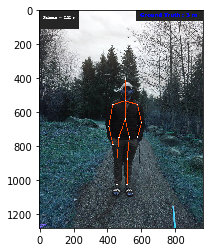

examples/annotated/750.jpg
time is  0.6958742141723633
headToNeck =  36.0
distance =  10.529972561117676


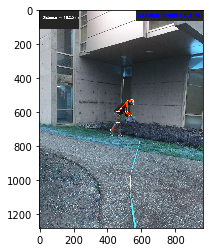

examples/annotated/400.jpg
time is  0.6990599632263184
headToNeck =  86.83317338436964
distance =  4.832194687980122


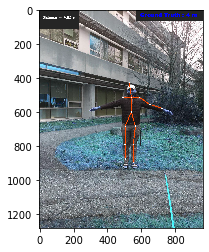

examples/annotated/500.jpg
time is  0.9412510395050049
headToNeck =  89.28605714219886
distance =  4.247698461689698


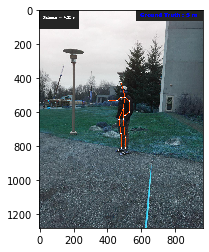

examples/annotated/600.jpg
time is  0.8117270469665527
headToNeck =  85.84287972802403
distance =  3.875742030624748


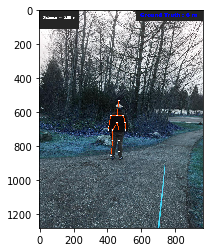

examples/annotated/200.jpg
time is  0.9124569892883301
headToNeck =  149.0
distance =  2.177541344207805


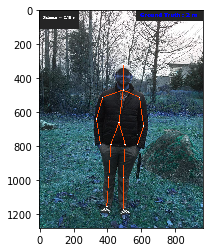

examples/annotated/130.jpg
time is  0.7594640254974365
headToNeck =  235.0
distance =  1.404667352425291
too close! keep distance


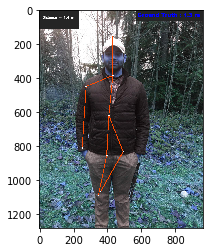

In [11]:
# run pose and distance.
viz = pose_distance(depth_maps[:,:].copy(), inputs.copy(), glob.glob(input))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


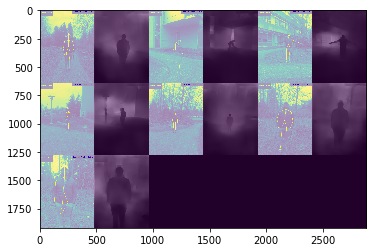

In [12]:
plt.imshow(viz[:,:,:])
plt.imshow(viz[:,:,0], alpha=0.5)
plt.show()